In [1]:
from raytracing.interaction import Edge, Surface
from raytracing.plotting import new_3d_axes
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from diffraction import Wave, Edge as DiffEdge, diffracted_field, reflected_field

/export/home/eertmans/.virtualenvs/RayTracing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
filename = "broadway_simu.pickle"
filename = "010_simu.pickle"

with open(filename, 'rb') as f:
    simu = pickle.load(f)

<IPython.core.display.Javascript object>


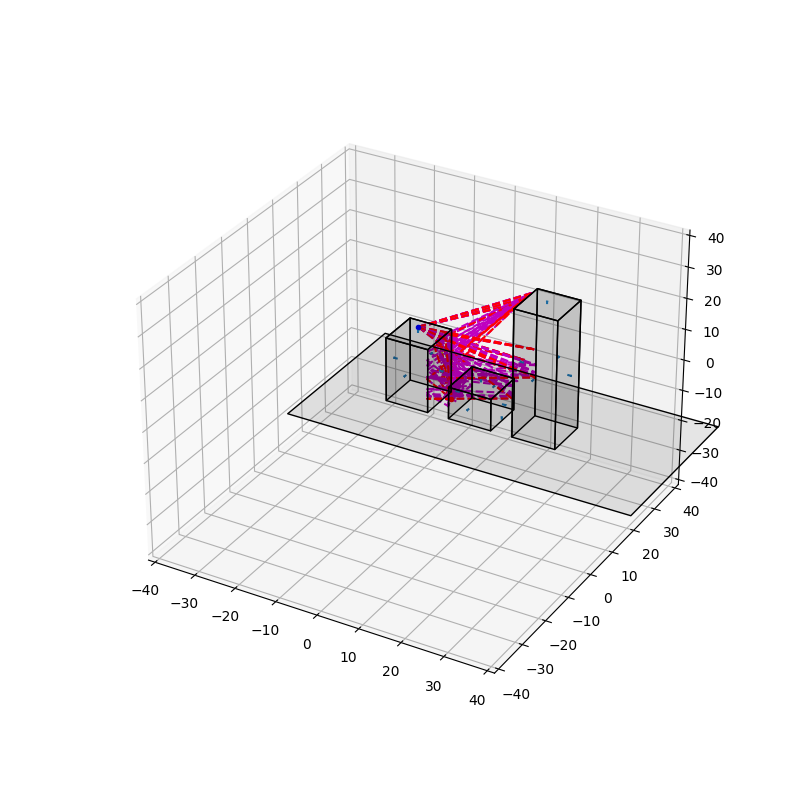

In [3]:
%matplotlib notebook

ax = new_3d_axes(figsize=(8, 8))

paths = simu.paths

show = 0

if isinstance(show, int):
    simu.paths = {show: simu.paths[show]}
elif show is None:
    simu.paths = {}
    
simu.on(ax).plot()
    
simu.paths = paths


In [4]:
paths = simu.paths

def length(path):
    return np.linalg.norm(path.points, axis=1).sum()

# def path_los_fs_db(path):
#     c = 3e8
#     d = length(path)
#     f = 26e9
#     fspl = (4*np.pi*d*f/c)
    
#     return 20 * np.log10(fspl)

# def path_los_diff_db(path):
    
#     loss = 0
    
#     def _loss(angle):
        
#         angle = np.rad2deg(angle)
        
#         """
#         if angle < 5:
#             return 5 * np.log(angle) + 18
#         else:
#             return 0.74 * angle + 25
#         """
#         #return 0.96 * angle + 6.03
#         return 0.5702 * 28 + 0.9078 * angle - 4.9056
    
#     for i, interaction in enumerate(path.interact_list):
#         if isinstance(interaction, Edge):
#             v_in, v_out = np.diff(path.points[i:i+3, :], axis=0)
#             cos = np.dot(v_in, v_out) / (np.linalg.norm(v_in) * np.linalg.norm(v_out))
#             angle = np.arccos(cos)
            
#             loss += _loss(angle)
            
#     return loss

def path_loss_db(path, f=1e9):
    E = np.zeros(3, dtype=complex)
    
    wave = Wave(f)
    
    k = wave.k
    
    v = np.diff(path.points[0:2, :], axis=0).reshape(-1)
    r = np.linalg.norm(v)
    theta = np.arctan2(v[2], np.linalg.norm(v[:2]))
    ejkr_r = np.exp(-1j * k * r) / r  # Path loss
    theta_dir = np.array([np.cos(theta), 0, -np.sin(theta)])

    field = np.sin(theta) * ejkr_r * theta_dir
    for i, interaction in enumerate(path.interact_list):
        if isinstance(interaction, Edge):
            edge = DiffEdge(interaction.tangent(None), [interaction.parent_surface_1.normal(), interaction.parent_surface_2.normal()])
            field = diffracted_field(field, path.points[i:i+3, :], edge, wave)
        elif isinstance(interaction, Surface):
            field = reflected_field(field, path.points[i:i+3, :], interaction.normal(), wave)
            
    return 20 * np.log10(np.linalg.norm(field))
    #return path_los_diff_db(path) + path_los_fs_db(path)

def n_refl(path):
    return sum(1 for interaction in path.interact_list if isinstance(interaction, Surface))

def n_diff(path):
    return sum(1 for interaction in path.interact_list if isinstance(interaction, Edge))

def diff_indices(path):
    return format(sum((1 << i ) * isinstance(interaction, Edge) for i, interaction in enumerate(path.interact_list)), f'0{len(path) - 2}b')

data = [(receiver, length(path), len(path) - 2, diff_indices(path), path_loss_db(path)) for receiver, paths in paths.items() for path in paths]

/export/home/eertmans/repositories/RayTracing/diffraction.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / tan(x)
/export/home/eertmans/repositories/RayTracing/diffraction.py:57: RuntimeWarning: invalid value encountered in cdouble_scalars
  factor


In [5]:

df = pd.DataFrame(data, columns=("receiver", "length", "n_interact", "diff_indices", "path_loss"))

df.groupby(["receiver", "n_interact", "diff_indices"]).describe(percentiles=[])

length                                     \
                                  count        mean        std         min   
receiver n_interact diff_indices                                             
0        1          1               1.0   50.861739        NaN   50.861739   
         2          01              2.0   74.566938  16.144891   63.150775   
                    10              1.0   83.440040        NaN   83.440040   
                    11              8.0   80.583629  12.748124   65.003875   
         3          001             1.0  101.378249        NaN  101.378249   
                    010             1.0   95.729076        NaN   95.729076   
                    011             9.0   93.932969  14.275514   72.074943   
                    100             1.0   86.335390        NaN   86.335390   
                    101             5.0   99.649296  11.597674   86.945409   
                    110             3.0   91.097695   5.615725   87.855454   
                    111            23.0   95.123365  13.636274   74.922930   

                                                         path_loss  \
                                         50%         max     count   
receiver n_interact diff_indices                                     
0        1          1              50.861739   50.861739       1.0   
         2          01             74.566938   85.983100       2.0   
                    10             83.440040   83.440040       1.0   
                    11             83.955436   98.031645       8.0   
         3          001           101.378249  101.378249       1.0   
                    010            95.729076   95.729076       1.0   
                    011            96.272591  110.320681       9.0   
                    100            86.335390   86.335390       1.0   
                    101           108.017177  108.321307       5.0   
                    110            87.855454   97.582176       3.0   
                    111            88.205501  112.173781      21.0   

                                                                     \
                                        mean        std         min   
receiver n_interact diff_indices                                      
0        1          1             -58.700742        NaN  -58.700742   
         2          01           -269.177742  19.081943 -282.670713   
                    10           -269.295454        NaN -269.295454   
                    11           -104.151995  19.016849 -127.738140   
         3          001          -248.341190        NaN -248.341190   
                    010          -268.814974        NaN -268.814974   
                    011          -163.935151  86.200098 -288.006525   
                    100          -243.215853        NaN -243.215853   
                    101          -149.540024  71.585588 -276.533362   
                    110          -174.641337  98.773798 -288.637381   
                    111          -130.345261  18.842493 -166.355153   

                                                          
                                         50%         max  
receiver n_interact diff_indices                          
0        1          1             -58.700742  -58.700742  
         2          01           -269.177742 -255.684771  
                    10           -269.295454 -269.295454  
                    11           -102.077189  -71.838495  
         3          001          -248.341190 -248.341190  
                    010          -268.814974 -268.814974  
                    011          -125.709909  -87.880704  
                    100          -243.215853 -243.215853  
                    101          -125.458248 -105.498540  
                    110          -120.796046 -114.490584  
                    111          -128.447426  -89.101235

In [6]:
df.drop(["receiver", "length"], axis=1).groupby(["n_interact", "diff_indices"]).describe(percentiles=[])

path_loss                                     \
                            count        mean        std         min   
n_interact diff_indices                                                
1          1                  1.0  -58.700742        NaN  -58.700742   
2          01                 2.0 -269.177742  19.081943 -282.670713   
           10                 1.0 -269.295454        NaN -269.295454   
           11                 8.0 -104.151995  19.016849 -127.738140   
3          001                1.0 -248.341190        NaN -248.341190   
           010                1.0 -268.814974        NaN -268.814974   
           011                9.0 -163.935151  86.200098 -288.006525   
           100                1.0 -243.215853        NaN -243.215853   
           101                5.0 -149.540024  71.585588 -276.533362   
           110                3.0 -174.641337  98.773798 -288.637381   
           111               21.0 -130.345261  18.842493 -166.355153   

                                                 
                                50%         max  
n_interact diff_indices                          
1          1             -58.700742  -58.700742  
2          01           -269.177742 -255.684771  
           10           -269.295454 -269.295454  
           11           -102.077189  -71.838495  
3          001          -248.341190 -248.341190  
           010          -268.814974 -268.814974  
           011          -125.709909  -87.880704  
           100          -243.215853 -243.215853  
           101          -125.458248 -105.498540  
           110          -120.796046 -114.490584  
           111          -128.447426  -89.101235

In [15]:
df["E"] = 10**(df["path_loss"]/20)

E_tot = df.drop(["receiver", "length", "path_loss"], axis=1).groupby(["n_interact", "diff_indices"]).sum()

20 *np.log10(E_tot)

E
n_interact diff_indices            
1          1             -58.700742
2          01           -255.304601
           10           -269.295454
           11            -69.843673
3          001          -248.341190
           010          -268.814974
           011           -82.521070
           100          -243.215853
           101          -101.264367
           110          -111.062679
           111           -84.689664